# Amazon Laptop Market Analysis

## Part 1: Web Scraping

In this section, we will scrape laptop data from Amazon (minimum 100 products). We will extract the following fields:
- product_title
- Brand
- RAM
- Storage SSD
- Windows version (10, 11, 12, etc.)
- Color
- Price
- Rating (0 to 5)
- Processor
- Screen Size
- Optionals

In [ ]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random

session = requests.Session()

headers = {
    "authority": "www.amazon.in",
    "method": "GET",
    "scheme": "https",
    "accept": "text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8",
    "accept-language": "en-US,en;q=0.9",
    "cache-control": "no-cache",
    "dnt": "1",
    "upgrade-insecure-requests": "1",
    "user-agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36"
}

session.headers.update(headers)

def scrape_page(page):
    
    url = f"https://www.amazon.in/s?k=laptop&page={page}"
    response = session.get(url)
    
    soup = BeautifulSoup(response.text, "lxml")
    products = soup.select(".s-result-item[data-component-type='s-search-result']")

    page_data = []    
    
    for item in products:
        title = item.select_one("h2 span")
        price = item.select_one(".a-price-whole")
        rating = item.select_one(".a-icon-alt")
        reviews = item.select_one(".a-size-base.s-underline-text")

        page_data.append({

            "title": title.text.strip() if title else None,
            "price": price.text.strip().replace(",", "") if price else None,
            "rating": rating.text.split()[0] if rating else None,
            "reviews": reviews.text.strip() if reviews else None
        })
        
    print(f"Page {page} → {len(page_data)} items scraped")
    return page_data

all_laptops = []


for page in range(1,8):
    try:
        data = scrape_page(page)
        all_laptops.extend(data)
        time.sleep(random.uniform(2,4))  # behave like human
    except:
        print("Blocked... retrying")
        time.sleep(5)

df = pd.DataFrame(all_laptops)



# remove empty titles
df = df[df['title'].notna()]


df.shape
df.to_csv("amazon_laptop_raw.csv", index=False)
print("RAW dataset saved")

Page 1 → 22 items scraped
Page 2 → 21 items scraped
Page 3 → 22 items scraped
Page 4 → 22 items scraped
Page 5 → 22 items scraped
Page 6 → 22 items scraped
Page 7 → 22 items scraped
RAW dataset saved


## Part 2: DataFrame Creation

In this section, we will:
- Create a Pandas DataFrame
- Check shape, info, missing values
- Remove duplicates
- Convert price columns to numeric
- Extract brand from title if not directly available
- Extract features like RAM, Storage, Processor, Windows version, Screen size, and Color from the title

In [ ]:
import pandas as pd
import re
df = pd.read_csv("amazon_laptop_raw.csv")
df.head()

# price numeric
df['price'] = df['price'].astype(str).str.replace(',', '', regex=False)
df['price'] = pd.to_numeric(df['price'], errors='coerce')


# rating numeric
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')


# drop duplicates
df = df.drop_duplicates(subset='title')


df.shape

def extract_features(title):
    title = str(title)


    brand = re.match(r"^\w+", title)
    brand = brand.group() if brand else None


    ram = re.search(r"(\d+)\s?GB\s?RAM", title, re.I)
    ram = ram.group(1)+"GB" if ram else None


    storage = re.search(r"(\d+)\s?(GB|TB)\s?(SSD|HDD)", title, re.I)
    storage = storage.group() if storage else None


    processor = re.search(r"(i[3579]|Ryzen\s?\d)", title, re.I)
    processor = processor.group() if processor else None


    windows = re.search(r"(Windows|Win)\s?(\d+)", title, re.I)
    windows = "Windows " + windows.group(2) if windows else None


    screen = re.search(r"(\d+(\.\d+)?)\s?(Inch|inches|\"|\')", title, re.I)
    screen = screen.group(1) if screen else None


    color = re.search(r"(Black|Silver|Blue|Grey|Gray|White)", title, re.I)
    color = color.group() if color else None


    return pd.Series([brand, ram, storage, processor, windows, screen, color])

df[['brand','ram','storage','processor','windows','screen_size','color']] = df['title'].apply(extract_features)



df.head()

,title,price,rating,reviews,brand,ram,storage,processor,windows,screen_size,color
0,"HP Omnibook 5 OLED, Snapdragon X Processor (16...",69990.0,4.1,NaN,HP,NaN,1TB SSD,NaN,Windows 11,16,Silver
1,"Primebook 2 Neo 2025 (New Launch) | 6GB RAM, 1...",15990.0,4.4,NaN,Primebook,6GB,NaN,NaN,NaN,NaN,NaN
2,"BrowseBook 14.1"" FHD IPS Laptop | Best Student...",12990.0,3.0,NaN,BrowseBook,4GB,128GB SSD,NaN,Windows 11,14.1,Grey
3,"HP 15, 13th Gen Intel Core i3-1315U (12GB DDR4...",41990.0,4.1,NaN,HP,NaN,512GB SSD,i3,Windows 11,15.6,Silver
4,"EBook 11.6"" HD Laptop | Best Student & Office ...",10990.0,5.0,NaN,EBook,NaN,NaN,NaN,Windows 11,11.6,Black


## Part 3: Save Files

In this section, we will save the processed data to CSV files:
- amazon_laptop_raw.csv - The raw scraped data
- amazon_laptop_cleaned.csv - The cleaned and processed data

In [34]:
df = df.dropna(subset=['price','rating'])
df.reset_index(drop=True, inplace=True)



df.info()

df.to_csv("amazon_laptop_cleaned.csv", index=False)
print("Cleaned dataset saved")

<class 'pandas.DataFrame'>
RangeIndex: 111 entries, 0 to 110
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   title        111 non-null    str    
 1   price        111 non-null    float64
 2   rating       111 non-null    float64
 3   reviews      0 non-null      float64
 4   brand        111 non-null    str    
 5   ram          54 non-null     str    
 6   storage      91 non-null     str    
 7   processor    66 non-null     str    
 8   windows      98 non-null     str    
 9   screen_size  95 non-null     str    
 10  color        98 non-null     str    
dtypes: float64(3), str(8)
memory usage: 9.7 KB
Cleaned dataset saved


## Part 4: Analysis Questions

In this section, we will answer the following analysis questions:
1. Which brand has highest average price?
2. Which brand has highest average rating?
3. Top 5 most reviewed laptops?
4. What is the average discount percentage?
5. Price vs Rating correlation value?
6. Distribution of laptops by RAM (8GB, 16GB, etc.)
7. Which screen size is most common?
8. How many laptops under ₹50,000?

In [35]:
# 1. Which brand has highest average price?
df.groupby('brand')['price'].mean().sort_values(ascending=False).head(1)

brand
Microsoft    179190.0
Name: price, dtype: float64

In [36]:
# 2. Which brand has highest average rating?
df.groupby('brand')['rating'].mean().sort_values(ascending=False).head(1)

brand
EBook    5.0
Name: rating, dtype: float64

In [37]:
# 3. Top 5 most reviewed laptops
df.sort_values(by='reviews', ascending=False)[['title','reviews']].head(5)

,title,reviews
0,"HP Omnibook 5 OLED, Snapdragon X Processor (16...",NaN
1,"Primebook 2 Neo 2025 (New Launch) | 6GB RAM, 1...",NaN
2,"BrowseBook 14.1"" FHD IPS Laptop | Best Student...",NaN
3,"HP 15, 13th Gen Intel Core i3-1315U (12GB DDR4...",NaN
4,"EBook 11.6"" HD Laptop | Best Student & Office ...",NaN


In [38]:
# 4. What is the average discount percentage?
# Note: Original price vs current price calculation would require original price data
# For now, we show basic price statistics
df['price'].describe()

count       111.000000
mean      59940.693694
std       41215.934430
min         298.000000
25%       37783.000000
50%       52430.000000
75%       72740.000000
max      243990.000000
Name: price, dtype: float64

In [39]:
# 5. Price vs Rating correlation value
df[['price','rating']].corr()

,price,rating
price,1.000000,0.103279
rating,0.103279,1.000000


In [40]:
# 6. Distribution of laptops by RAM (8GB, 16GB, etc.)
df['ram'].value_counts()

ram
16GB    29
8GB     13
4GB      5
32GB     3
24GB     2
6GB      1
12GB     1
Name: count, dtype: int64

In [41]:
# 7. Which screen size is most common?
df['screen_size'].mode()

0    15.6
Name: screen_size, dtype: str

In [42]:
# 8. How many laptops under ₹50,000?
(df['price'] < 50000).sum()

np.int64(53)

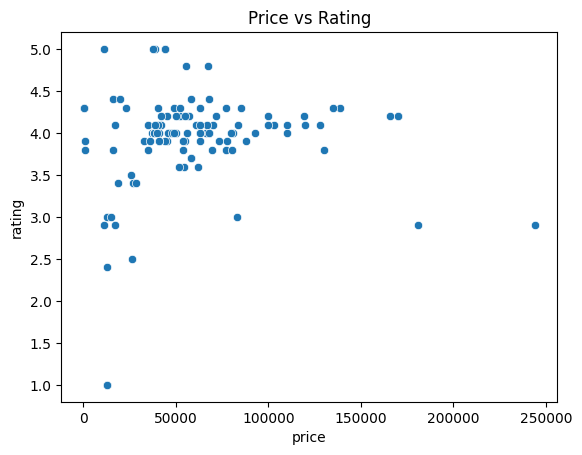

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt



sns.scatterplot(x=df['price'], y=df['rating'])
plt.title("Price vs Rating")
plt.show()